In [21]:
!pip install wordcloud
!pip install spacy
!pip install textblob

  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached langcodes-3.5.0-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.3.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
  Using cached cloudpathlib-0.21.0-py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.1 MB/s eta 0:00:00
Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
Using cached langcodes-3.5.0-py3-none-any.whl (182 kB)
Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl (29 kB)
Using cached spacy_loggers-1.0.5-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.4/634.4 kB 26.3 MB/s eta 0:00:00
   ━━━━━

### Import necessary libraries

In [24]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### Import the training dataset

In [31]:
#importing the training data
imdb_data=pd.read_csv('/Users/hotpotato/Desktop/Final Project/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Exploratery data analysis

In [34]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Sentiment count

In [106]:
#sentiment count
imdb_data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

### Spliting the training dataset

In [109]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


## Step 1: Text normalization
1. Tokenization: Split text into individual words (tokens).
2. Normalization: Convert to lowercase and remove extra spaces.
3. Stemming: Reduce words to their root form (e.g., "running" → "run").
4. Remove HTML & Noise: Strip HTML tags and unwanted markup.
5. Remove Special Characters: Eliminate non-alphanumeric symbols.
6. Remove Stopwords: Filter out common, low-information words (e.g., "the", "is").



In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hotpotato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenizer

In [26]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### Removing html strips and noise text

In [36]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(str(text), "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Apply the cleaning function
imdb_data['review'] = imdb_data['review'].apply(denoise_text)


/var/folders/x6/dbkrtxl50n57204wss8d8p5r0000gn/T/ipykernel_45515/2784830668.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), "html.parser")


### Removing special characters

In [39]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

### Text stemming

In [42]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

### Removing stopwords

In [44]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'being', 'were', 'yourselves', 'been', 'as', 'some', 'just', 'at', 'nor', 'why', "you'd", "mightn't", 'from', "that'll", 'couldn', "you'll", "i'd", 're', "shan't", 'further', 'against', "hadn't", "won't", 'there', 'can', "should've", 'a', 'in', 'such', 'any', 'isn', 'down', 'did', 'for', 'their', 'them', 'until', 'wasn', "aren't", 'your', 'what', 'and', 'while', 'do', 'who', 'doing', 'between', 'her', 'each', 'his', 'our', 'more', 'mustn', 'yourself', 'before', 'into', 'theirs', 'itself', "shouldn't", 'than', 'which', "needn't", 'ourselves', 'above', 'no', 'ours', 'to', 'him', 'off', "wasn't", "hasn't", 'was', 'don', "it'll", 'my', 'weren', 'other', 'will', "isn't", 'when', 'aren', "couldn't", "mustn't", 've', 'won', 'very', 'ma', "we'd", 'doesn', 'you', 'she', 'shan', "he'll", 'have', "i'm", 'about', 'he', "we'll", 'same', 'that', 'on', "we're", 'yours', 'under', 'should', 'but', 'these', "she'd", "doesn't", 't', 'where', 'll', 'up', 's', 'again', 'its', 'own', 'an', "we've", "don't"

### Normalized train reviews

In [49]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

### Normalized test reviews

In [52]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

## Word cloud 

### For positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

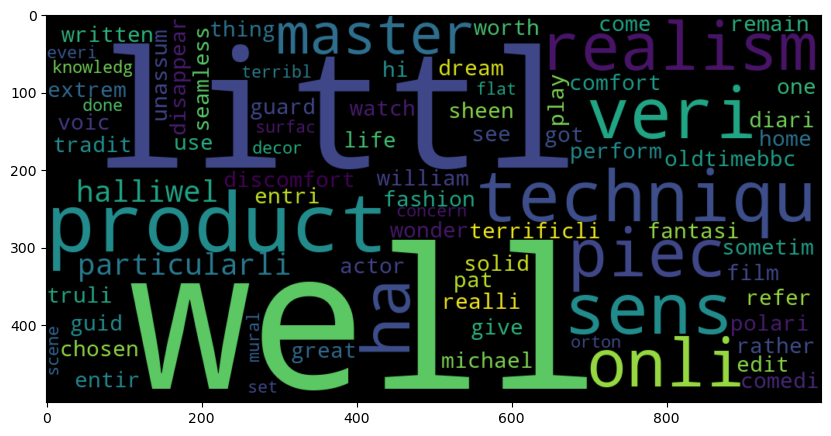

In [137]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

#### Positive Words
Key positive terms include:
Words like “film”, “perform”, “wonder”, “decor” and “fashion” point to appreciation for production value, acting, or aesthetic.
Sentiment-bearing adjectives like “worth”, “solid”, and “seamless” reinforce genuine praise.

### For negative review words

<function matplotlib.pyplot.show(close=None, block=None)>

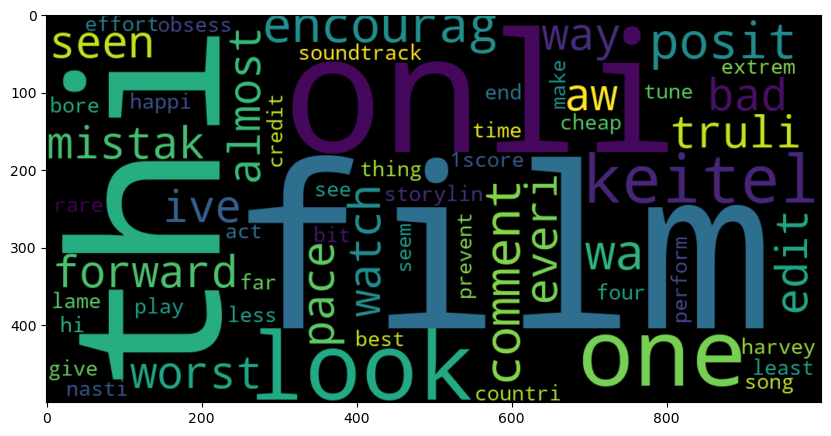

In [141]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

#### Negative Words
The most prominent words include:
Some surprising entries like “posit”, “encourag”, “truli” may appear due to misclassification, stemming errors, or sarcastic usage (e.g., “truly disappointing”).
Names like “keitel” and “harvey” (possibly from actor mentions) also show up, suggesting some reviews focus on specific performances that might have been poorly received.

## Step 2 :Feature Selection

### Bags of words model
The Bag of Words (BoW) model is a basic and widely used method in text analysis. It represents text data by counting how often each word appears, while ignoring grammar and word order.

How it works:
Build a vocabulary of all unique words across the dataset.
For each document (e.g., a review), count how many times each word from the vocabulary appears.
Represent the document as a vector of word counts.



In [146]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (40000, 6983231)
BOW_cv_test: (10000, 6983231)


### Term Frequency-Inverse Document Frequency model (TFIDF)

TF-IDF is a widely used method to represent text data by measuring how **important** a word is to a document **relative to a collection of documents**.

1. **Term Frequency (TF)**
   Measures how often a term appears in a document:

   ```math
   TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in } d}
   ```

2. **Inverse Document Frequency (IDF)**
   Measures how unique or rare a term is across documents:

   ```math
   IDF(t) = \log\left(\frac{N}{1 + DF(t)}\right)
   ```

   * *N*: total number of documents
   * *DF(t)*: number of documents containing term *t*

3. **TF-IDF Score**
   The final score combines term frequency and inverse document frequency:

   ```math
   TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
   ```

**Advantages of TF-IDF**

* Reduces the weight of **common words** (e.g., "the", "is")
* Highlights **important, rare words** that distinguish documents
* Performs better than raw word counts in many **text classification and search tasks**



In [148]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6983231)
Tfidf_test: (10000, 6983231)


## Step 3: Do label encoding and data partitioning

#### 1. Labeling the sentiment text

In [153]:
#labeling the sentiment data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


#### 2. Split the sentiment data

In [156]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Step 4: Modelling the dataset
### 1. Logistic regression model for both bag of words and tfidf features

In [159]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments.ravel())
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments.ravel())
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


### Logistic regression model performane on test dataset

In [162]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


### Accuracy 

In [165]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8397
lr_tfidf_score : 0.8873


### Print the classification report

In [170]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.80      0.91      0.85      4993
    Negative       0.90      0.77      0.83      5007

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

              precision    recall  f1-score   support

    Positive       0.89      0.89      0.89      4993
    Negative       0.89      0.89      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Confusion matrix

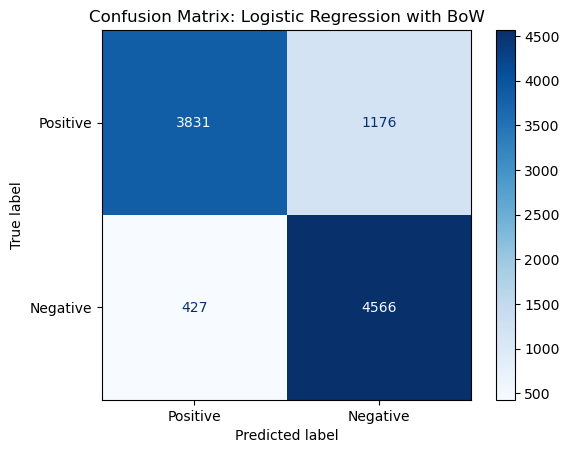

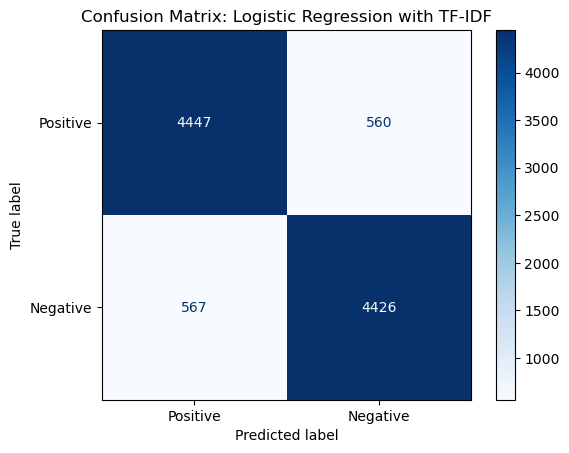

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# --- Confusion Matrix for Bag of Words ---
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=['Positive', 'Negative'])
disp_bow.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Logistic Regression with BoW")
plt.show()

# --- Confusion Matrix for TF-IDF ---
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['Positive', 'Negative'])
disp_tfidf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Logistic Regression with TF-IDF")
plt.show()


### **Conclusion:**

* **TF-IDF performs better than BoW**:

  * Logistic Regression with TF-IDF results in **higher true positive (4447)** and **true negative (4426)** predictions compared to BoW.
  * BoW shows **more false positives (1176)** and **slightly fewer true negatives (4566)** but at the cost of many more **false negatives (427)**.

* **BoW model favors negative classification**:

  * Higher precision for detecting negatives (many false positives for positive class).
  * Likely overfits to frequent patterns without considering word importance.

* **TF-IDF is more balanced**:

  * It penalizes common words and emphasizes distinctive terms, making it more reliable for sentiment classification.


#### Save the model

In [167]:
import joblib
# Save the Bag-of-Words model
joblib.dump(lr_bow, 'logistic_bow_model.pkl')
# Save the TF-IDF model
joblib.dump(lr_tfidf, 'logistic_tfidf_model.pkl')


['logistic_tfidf_model.pkl']

### 2. Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [188]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments.ravel())
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments.ravel())
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


### Model performance on test data

In [191]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


### Accuracy

In [194]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.8433
svm_tfidf_score : 0.8869


### Print the classification report

In [197]:
#Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.80      0.91      0.85      4993
    Negative       0.90      0.77      0.83      5007

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

              precision    recall  f1-score   support

    Positive       0.90      0.88      0.89      4993
    Negative       0.88      0.90      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### Plot the confusion matrix

SVM BoW Accuracy: 0.8433


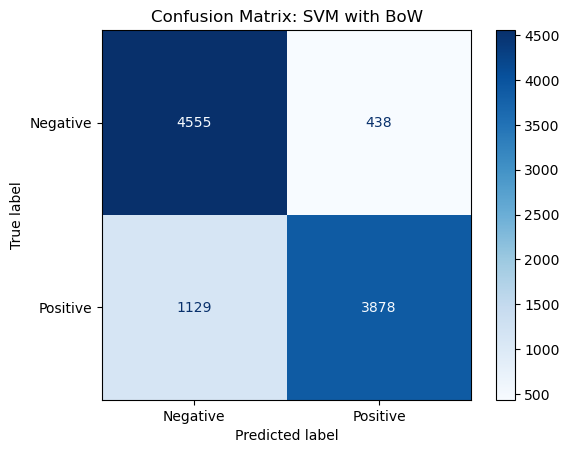

SVM TF-IDF Accuracy: 0.8869


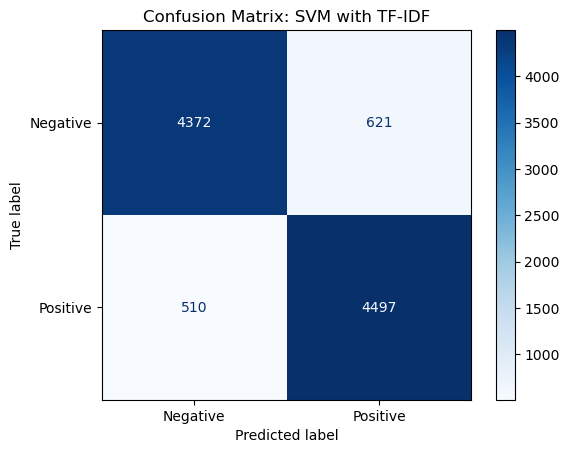

In [200]:

# Bag of Words Confusion Matrix for SVM
cm_svm_bow = confusion_matrix(test_sentiments, svm_bow_predict)
print("SVM BoW Accuracy:", accuracy_score(test_sentiments, svm_bow_predict))

disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_svm_bow, display_labels=['Negative', 'Positive'])
disp_bow.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: SVM with BoW")
plt.show()

# TF-IDF Confusion Matrix for SVM
cm_svm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict)
print("SVM TF-IDF Accuracy:", accuracy_score(test_sentiments, svm_tfidf_predict))

disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_svm_tfidf, display_labels=['Negative', 'Positive'])
disp_tfidf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: SVM with TF-IDF")
plt.show()


### **Conclusion:**

The **SVM model with TF-IDF features** outperforms the one using Bag-of-Words (BoW), achieving a higher accuracy of **0.8869** versus **0.8433**. It also produces fewer false positives (510 vs. 1129) and maintains better balance between precision and recall. This suggests that TF-IDF captures more informative and discriminative features by down-weighting common terms and emphasizing rarer, more meaningful ones—making it more effective for sentiment classification than simple word frequency counts.


#### Save the Model

In [207]:
joblib.dump(cm_svm_bow, 'svm_bow_model.pkl')
joblib.dump(cm_svm_tfidf, 'svm_tfidf_model.pkl')


['svm_tfidf_model.pkl']

### 3. XGBoost Model using TF-IDF features

In [212]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 23.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [217]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize and train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(tv_train_reviews, train_sentiments.ravel())

# Predict and evaluate
xgb_preds = xgb_model.predict(tv_test_reviews)
print("XGBoost Accuracy:", accuracy_score(test_sentiments, xgb_preds))

XGBoost Accuracy: 0.8542


In [219]:
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

### 4. CNN model

### Install Required Package

In [223]:
!pip install tensorflow

In [231]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [248]:
conda install python=3.10

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Applications/Anaconda/anaconda3

  added / updated specs:
    - python=3.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2025.04  | py310_openblas_0          63 KB
    aext-assistant-4.1.0       |py310hca03da5_jl4_0         4.1 MB
    aext-assistant-server-4.1.0|  py310hca03da5_0          20 KB
    aext-core-4.1.0            |py310hca03da5_jl4_0         228 KB
    aext-core-server-4.1.0     |  py310hca03da5_0          12 KB
    aext-panels-4.1.0          |  py310hca03da5_0         3.2 MB
    aext-panels-server-4.1.0   |  py310hca03da5_0          83 KB
    aext-project-filebrowser-server-4.1.0|  py310hb41f31a_0         247 KB
    aext-share-notebook-4.1.0  |  py310hca03da5_0         541 KB
    aext-share-notebook-server-4.1.0|  py310hca03da5_0          1

In [264]:
!pip uninstall -y numpy
!pip install numpy==1.24.3

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
  Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)


In [1]:
import numpy as np
print(np.__version__)

1.24.3


### Load and Preprocess Data

In [57]:
import nltk

nltk.download('punkt')              
nltk.download('punkt_tab')          
nltk.download('popular')           

from nltk.tokenize import word_tokenize
print(word_tokenize("Hello, world!"))


[nltk_data] Downloading package punkt to /Users/hotpotato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hotpotato/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/hotpotato/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/hotpotato/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/hotpotato/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/hotpotato/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |  

['Hello', ',', 'world', '!']


[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [59]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load dataset
df = pd.read_csv("/Users/hotpotato/Desktop/Final Project/IMDB Dataset.csv")

# Clean text
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\[[^]]*\]', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in tokens if word not in stop_words])

df['clean_review'] = df['review'].apply(clean_text)

# Encode labels
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hotpotato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/hotpotato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/x6/dbkrtxl50n57204wss8d8p5r0000gn/T/ipykernel_45515/773841641.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


### Split and Tokenize

In [7]:
!pip install tensorflow==2.16.2

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 39.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 28.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.9 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
Using cached gast-0.6.0-py3-none

In [62]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
maxlen = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

### Load GloVe Embeddings
Pre-trained word vectors that capture the semantic meaning of words based on global word co-occurrence statistics.By using GloVe, we can represent each word as a dense vector that reflects its relationships with other words, helping the model understand context and similarity (e.g., king – man + woman ≈ queen).

In [65]:
embedding_index = {}
with open("/Users/hotpotato/Desktop/Final Project/glove.840B.300d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
        except ValueError:
            continue

print("GloVe embeddings loaded:", len(embedding_index))

GloVe embeddings loaded: 2195884


### Create Embedding Matrix
Created by mapping each word in our dataset’s vocabulary to its corresponding GloVe vector. 
This matrix is then used to initialize the embedding layer in the CNN model, allowing it to start training with semantically meaningful word representations instead of random ones.

In [71]:
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(10000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

### Build and Train CNN Model

In [74]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import History

cnn_glove = Sequential()
cnn_glove.add(Embedding(input_dim=num_words,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=maxlen,
                        trainable=False))
cnn_glove.add(Conv1D(128, 5, activation='relu'))
cnn_glove.add(GlobalMaxPooling1D())
cnn_glove.add(Dense(64, activation='relu'))
cnn_glove.add(Dropout(0.5))
cnn_glove.add(Dense(1, activation='sigmoid'))

cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_glove.fit(X_train_pad, y_train,
                        epochs=5,
                        batch_size=128,
                        validation_split=0.2)

Epoch 1/5


/Applications/Anaconda/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.7344 - loss: 0.5085 - val_accuracy: 0.8631 - val_loss: 0.3264
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.8793 - loss: 0.2987 - val_accuracy: 0.8332 - val_loss: 0.3787
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9129 - loss: 0.2235 - val_accuracy: 0.8856 - val_loss: 0.2832
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9499 - loss: 0.1472 - val_accuracy: 0.8813 - val_loss: 0.3093
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9723 - loss: 0.0902 - val_accuracy: 0.8779 - val_loss: 0.3526


In [78]:
import joblib
joblib.dump(cnn_glove, 'cnn_glove.pkl')

['cnn_glove.pkl']

### Plot Accuracy & Loss

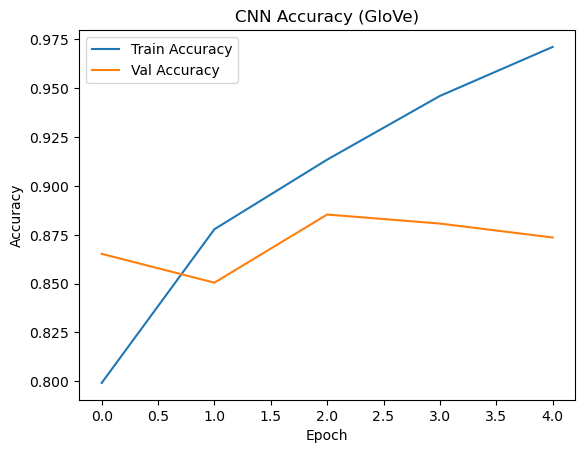

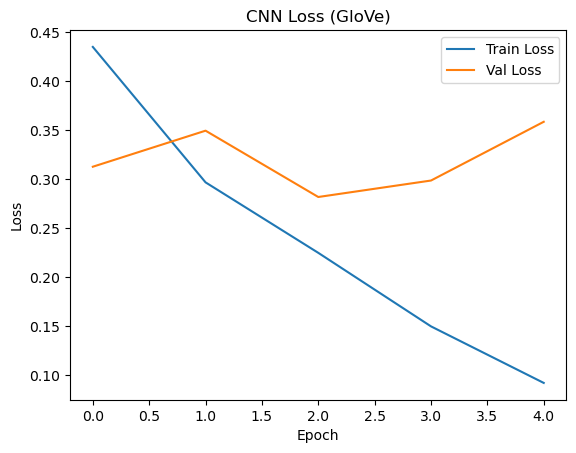

In [79]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Accuracy (GloVe)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Loss (GloVe)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
GloVe CNN Accuracy: 0.8657


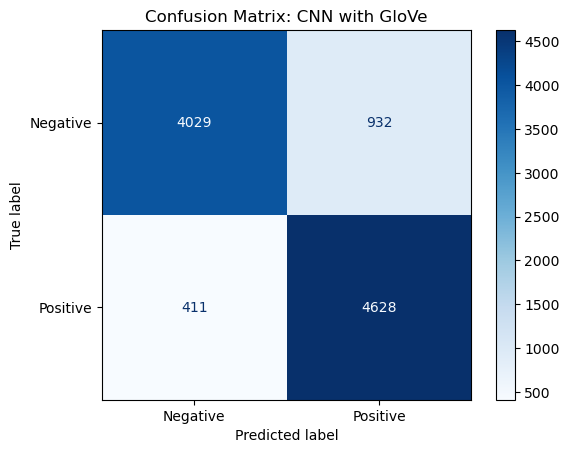

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

cnn_preds = (cnn_glove.predict(X_test_pad) > 0.5).astype("int32")
print("GloVe CNN Accuracy:", accuracy_score(y_test, cnn_preds))

cm = confusion_matrix(y_test, cnn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: CNN with GloVe")
plt.show()


Accuracy: 0.8657
→ The model correctly predicted ~86.6% of all reviews.
Strength: High recall for positive class (4628 / (4628 + 411) ≈ 91.8%), which is useful in applications where positive sentiment detection is important.

Weakness: Higher number of false positives (932) than false negatives, meaning it's more likely to mistake a negative review as positive.


## Conclusion


Among the four sentiment classification models, **SVM** and **Logistic Regression** performed best when combined with **TF-IDF vectorization**, achieving accuracies of **88.69%** and **88.73%**, respectively. These models are efficient and interpretable, making them strong baselines for text classification. In contrast, **XGBoost** reached an accuracy of **85.42%** without explicit vectorization details, showing stable performance but slightly lower predictive power than the TF-IDF-based models.

The **CNN with GloVe embeddings** achieved a solid test accuracy of **86.57%**, with particularly high recall for the positive class (91.8%). Training accuracy reached 97.5%, while validation accuracy peaked at epoch 3 and slightly declined afterward—indicating potential **overfitting**. The confusion matrix also reveals more false positives than false negatives, suggesting the model tends to overpredict positive sentiment. While the CNN captures rich semantic relationships, it may benefit from additional regularization or architectural tuning.

**Overall, SVM with TF-IDF achieved the highest accuracy and offers the best balance of performance and efficiency, making it the most effective model in this sentiment classification task.**


